<h2>Setup</h2>

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

llm = ChatOpenAI(model="gpt-4o", temperature=0)
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [3]:
# Test
response = llm.invoke("Hi")
response

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-abc7d6d2-faa3-473c-85b0-50cf2dcfa351-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

<h2>Retriever</h2>

In [4]:
### Retriever
from langchain_pinecone import PineconeVectorStore
from langchain_openai import OpenAIEmbeddings

index_name= "tactical-edge-rag-index"
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
vectorstore = PineconeVectorStore(index_name=index_name, embedding=embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

C:\Users\chenc\PycharmProjects\tactical-edge-rag\tactical-edge-rag-env\Lib\site-packages\pinecone\data\index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [5]:
# Test
question = "What is Mobily?"
documents = retriever.invoke(question)
print(documents[0].page_content)

Etihad Etisalat (Mobily) was established in 2004 through Saudi 
Arabia’s second Global System for Mobile Communications (GSM) 
license, ending the monopoly in the Saudi wireless industry and 
providing choice in national mobile telecommunications services 
to the Saudi population for the first time.
About Mobily
The Company has rapidly grown and diversified both 
organically and through strategic acquisitions over the 
years, driven by investment in cutting-edge infrastructure –


<h2>Router</h2>

In [6]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        description="Given a user question choose to route it to web search or a vectorstore.",
    )

# LLM with function call
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """
You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to Mobily and OCaterpillar.
Use the vectorstore for questions on these topics. Otherwise, use web-search. please show me your thinking process."""

human_msg = """
    User question: 
    {question}""" 

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", human_msg),
    ]
)

question_router = route_prompt | structured_llm_router

In [7]:
route_prompt.pretty_print()

================================ System Message ================================


You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to Mobily and OCaterpillar.
Use the vectorstore for questions on these topics. Otherwise, use web-search. please show me your thinking process.

================================ Human Message =================================


    User question: 
    {question}


In [8]:
source = question_router.invoke({"question": "When did Mobily established?"})

In [9]:
source

RouteQuery(datasource='vectorstore')

<h2>Documents Grader</h2>

In [10]:

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: int = Field(
        description="Documents are relevant to the question, 0 or 1"
    )

# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """
You are a grader assessing relevance of a retrieved document to a user question. 
If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
It does not need to be a stringent test. The goal is to filter out erroneous retrievals.
Give a binary score 0 or 1 score to indicate whether the document is relevant to the question."""

human_msg = """
    Retrieved documents: 
    {documents} 
    
    User question: 
    {question}""" 

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", human_msg),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

In [11]:
grade_prompt.pretty_print() 

================================ System Message ================================


You are a grader assessing relevance of a retrieved document to a user question. 
If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
It does not need to be a stringent test. The goal is to filter out erroneous retrievals.
Give a binary score 0 or 1 score to indicate whether the document is relevant to the question.

================================ Human Message =================================


    Retrieved documents: 
    {documents} 
    
    User question: 
    {question}


In [12]:
# Test
score = retrieval_grader.invoke({"question": question, "documents": documents}) #We can pass a list of documents, a single document or a string
type(score)

__main__.GradeDocuments

In [13]:
score.binary_score

1

<h2>Generate Answer</h2>

In [14]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt") #prompt has context and question parameter

# Chain
rag_chain = prompt | llm | StrOutputParser()

In [15]:
prompt.pretty_print() 

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [16]:
# Test
generation = rag_chain.invoke({"context": documents, "question": question})
print(generation)

Mobily, officially known as Etihad Etisalat, is a telecommunications company established in 2004 in Saudi Arabia. It was created through the country's second GSM license, breaking the monopoly in the Saudi wireless industry. Mobily is listed on the Saudi Exchange and is partially owned by the Etisalat Emirates Group.


<h2>Hallucination Grader</h2>

In [17]:
# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: int = Field(
        description="Answer is grounded in the facts, 0 or 1"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """
You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts.
Give a binary score 1 or 0. 1 means that the answer is grounded in / supported by the set of facts."""

human_msg = """
    Set of facts: 
    {documents} 
    
    LLM generation: 
    {generation}"""
    
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", human_msg),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader

In [18]:
hallucination_prompt.pretty_print() 

================================ System Message ================================


You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts.
Give a binary score 1 or 0. 1 means that the answer is grounded in / supported by the set of facts.

================================ Human Message =================================


    Set of facts: 
    {documents} 
    
    LLM generation: 
    {generation}


In [19]:
# Test
score = hallucination_grader.invoke({"documents": documents, "generation": generation})
type(score)

__main__.GradeHallucinations

In [20]:
score.binary_score

1

<h2>Answer Grader</h2>

In [21]:
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: int = Field(
        description="Answer addresses the question, 1 or 0"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """
You are a grader assessing whether an answer addresses / resolves a question.
Give a binary score 1 or 0. 1 means that the answer resolves the question."""

human_msg = """
    User question:
    {question} 
    
    LLM generation:
    {generation}""" 

answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", human_msg),
    ]
)

answer_grader = answer_prompt | structured_llm_grader

In [22]:
answer_prompt.pretty_print() 

================================ System Message ================================


You are a grader assessing whether an answer addresses / resolves a question.
Give a binary score 1 or 0. 1 means that the answer resolves the question.

================================ Human Message =================================


    User question:
    {question} 
    
    LLM generation:
    {generation}


In [23]:
# Test 
score = answer_grader.invoke({"question": question, "generation": generation})
type(score)

__main__.GradeAnswer

In [24]:
score.binary_score

1

<h2>Question Re-writer</h2>

In [25]:
# Prompt
system = """
You a question re-writer that converts an input question to a better version that is optimized for vectorstore retrieval. 
Look at the input and try to reason about the underlying semantic intent / meaning."""

human_msg = """
    Here is the initial question: 
    {question}
    
    Formulate an improved question.""" 

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", human_msg)
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()

In [26]:
re_write_prompt.pretty_print()

================================ System Message ================================


You a question re-writer that converts an input question to a better version that is optimized for vectorstore retrieval. 
Look at the input and try to reason about the underlying semantic intent / meaning.

================================ Human Message =================================


    Here is the initial question: 
    {question}
    
    Formulate an improved question.


In [27]:
# Test
better_question = question_rewriter.invoke({"question": question})
print(better_question)

What is Mobily and what services or products does it offer?


<h2>Web Search Tool</h2>

In [28]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(max_results=3)

In [29]:
# Test
docs = web_search_tool.invoke(better_question) #return a list of dict
type(docs)

list

In [30]:
print(docs[0]['content'])

Mobily (Arabic: موبايلي) is a Saudi Arabian telecommunications services company that offers fixed line, mobile telephony, and Internet services Mobily launched mobile services in Saudi Arabia on 5 May 2005, breaking Saudi Telecom's monopoly in the wireless business. M/40 dated 18 August 2004.[2] The company won the bid for Saudi Arabia's second GSM licence in the summer of 2004.[3] The licence is valid for 25 years.[4] Etihad Etisalat began its constituent activities on 14 December 2004 upon the publication of its incorporation.[2] Etihad Etisalat launched GSM mobile services under the brand name Mobily on 5 May 2005, breaking the Saudi Telecom Company's monopoly in the wireless business. ^ "Mobily Announces 4G LTE Service in Saudi Arabia (STC and Zain too) - SaudiMac".


<h2>Graph State</h2>

In [31]:
from typing import List
from typing_extensions import TypedDict
from langchain.schema import Document

class State(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        max_retries: Max number of retries for answer generation
        loop_step: number of loops for answer generation
        documents: list of documents
        
    """
    question: str
    generation: str
    max_retries: int
    loop_step: int
    documents: List[Document]

<h2>Retriever Node</h2>

In [32]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    
    return {"documents": documents}

<h2>Generate Node</h2>

In [33]:
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    loop_step = state.get("loop_step", 0)

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    
    return {"generation": generation, "loop_step": loop_step + 1}

<h2>Documents Grader Node</h2>

If any docs are relevant, we can proceed with generating answer

In [34]:
def grade(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for doc in documents:
        score = retrieval_grader.invoke(
            {"question": question, "documents": doc}
        )
        grade = score.binary_score 
        if grade == 1:
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(doc)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            
    return {"documents": filtered_docs}

<h2>Question Re-writer Node</h2>

In [35]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---Rewrite---")
    question = state["question"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    
    return {"question": better_question}

<h2>Web Search Node</h2>

In [36]:
def search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke(question)
    web_results = "\n".join([doc["content"] for doc in docs])
    documents = Document(page_content=web_results)

    return {"documents": documents}

<h2>Conditional Edge</h2>

In [37]:
from typing import Literal

def route_question(state) -> Literal["vectorstore", "web_search"]:
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [38]:
def decide_to_generate(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether to generate an answer, or rewrite a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUESTION---"
        )
        return "rewrite"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [39]:
def decide_to_answer(state) -> Literal["useful", "not useful", "not supported", "max retries"]:
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    max_retries = state.get("max_retries", 3)

    hallucination_score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    hallucination_grade = hallucination_score.binary_score

    # Check hallucination
    if hallucination_grade == 1:
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        answer_score = answer_grader.invoke({"question": question, "generation": generation})
        answer_grade = answer_score.binary_score
        if answer_grade == 1:
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        elif state["loop_step"] <= max_retries:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
        else:
            print("---DECISION: MAX RETRIES REACHED---")
            return "max retries"
    elif state["loop_step"] <= max_retries:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"
    else:
        print("---DECISION: MAX RETRIES REACHED---")
        return "max retries"

<h2>Compile Graph</h2>

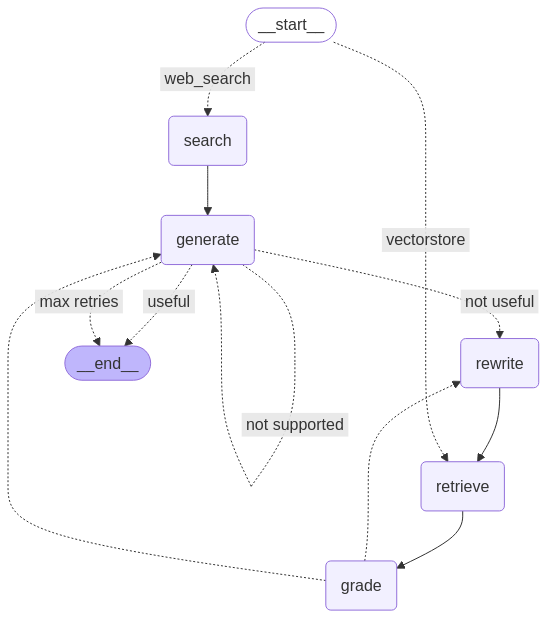

In [40]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(State)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade", grade)  # grade
workflow.add_node("generate", generate)  # generatae
workflow.add_node("rewrite", rewrite)  # rewrite
workflow.add_node("search", search)  # web search

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "search",
        "vectorstore": "retrieve",
    },
)

workflow.add_edge("search", "generate")
workflow.add_edge("retrieve", "grade")

workflow.add_conditional_edges(
    "grade",
    decide_to_generate,
    {
        "rewrite": "rewrite",
        "generate": "generate",
    },
)

workflow.add_edge("rewrite", "retrieve")
workflow.add_conditional_edges(
    "generate",
    decide_to_answer,
    {
        "useful": END,
        "not useful": "rewrite",
        "not supported": "generate",
        "max retries": END,
    },
)

# Compile
graph = workflow.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [41]:
import pprint

inputs = {"question": "What is Mobily?"}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint(value, indent=2, width=80, depth=None)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Output from node 'retrieve':"
{ 'documents': [ Document(id='2d73c238-dd97-44f9-8fed-d6fa8ecbfe7f', metadata={'creationdate': '', 'creator': 'PyPDF', 'moddate': '2023-05-24T12:46:42+00:00', 'page': 2.0, 'page_label': '3', 'producer': 'iLovePDF', 'source': 'data/Mobily AR_2022_English.pdf', 'total_pages': 99.0}, page_content='Etihad Etisalat (Mobily) was established in 2004 through Saudi \nArabia’s second Global System for Mobile Communications (GSM) \nlicense, ending the monopoly in the Saudi wireless industry and \nproviding choice in national mobile telecommunications services \nto the Saudi population for the first time.\nAbout Mobily\nThe Company has rapidly grown and diversified both \norganically and through strategic acquisitions over the \nyears, driven by investment in cutting-edge infrastructure –'),
                 Document(id='5ea5bc91-ef89-40ca-b064-45cd6dfa13d3', metadata={'creationdate': '', 'creator': 'PyP